[('PeriodicThermal', 'bodytrack', 3, 56.37, 257.54), ('PeriodicThermal', 'x264', 1, 51.84, 176.89), ('PeriodicPower', 'blackschole', 3, 0.32, 2.1), ('PeriodicPower', 'streamcluster', 2, 0.28, 1.99), ('PeriodicPower', 'fluidanimate', 1, 0.25, 4.85), ('PeriodicThermal', 'canneal', 1, 49.0, 136.83), ('PeriodicPower', 'blackschole', 1, 0.25, 1.93), ('PeriodicThermal', 'streamcluster', 2, 54.9, 140.03), ('PeriodicThermal', 'streamcluster', 3, 58.23, 137.99), ('PeriodicThermal', 'canneal', 2, 49.2, 136.7), ('PeriodicThermal', 'swaptions', 2, 57.32, 170.42), ('PeriodicPower', 'swaptions', 2, 0.32, 1.92), ('PeriodicPower', 'x264', 1, 0.25, 1.96), ('PeriodicThermal', 'blackschole', 1, 51.62, 162.56), ('PeriodicPower', 'swaptions', 3, 0.35, 1.92), ('PeriodicThermal', 'swaptions', 3, 60.52, 170.42), ('PeriodicPower', 'fluidanimate', 2, 0.26, 4.86), ('PeriodicThermal', 'x264', 3, 55.51, 170.89), ('PeriodicPower', 'streamcluster', 3, 0.32, 1.72), ('PeriodicThermal', 'streamcluster', 1, 51.26, 145.5

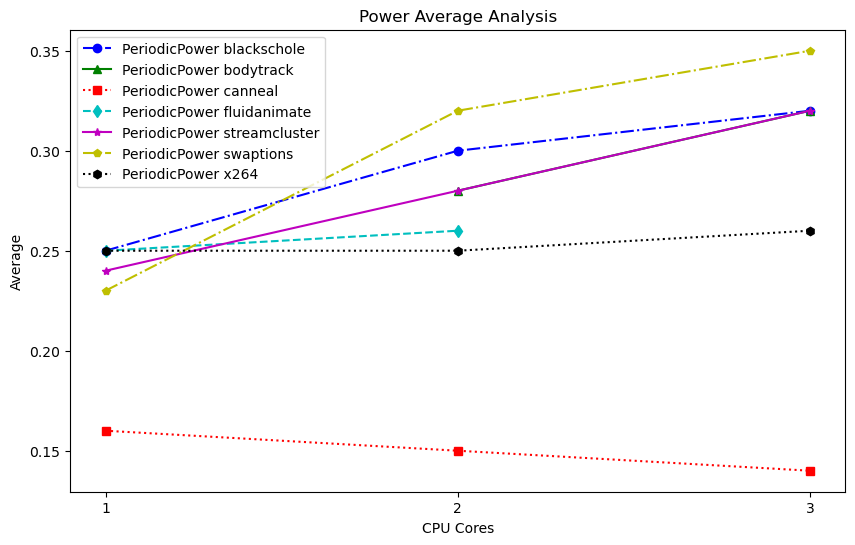

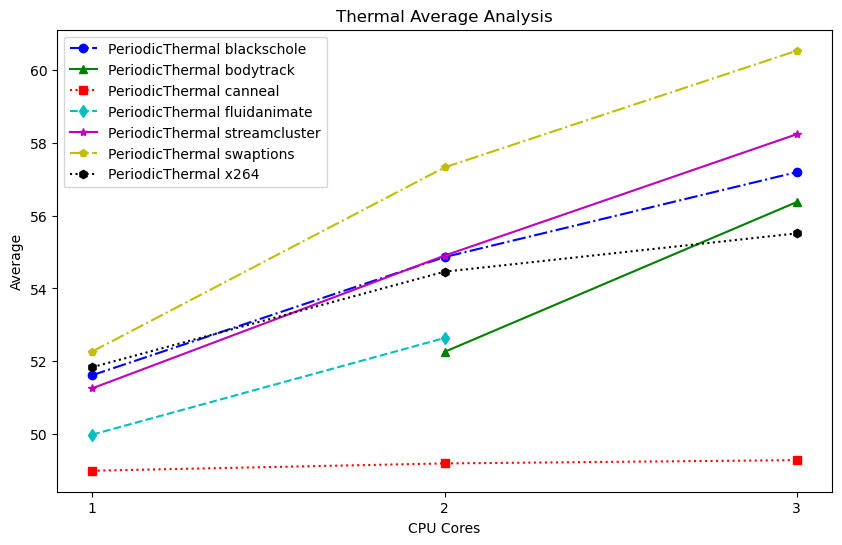

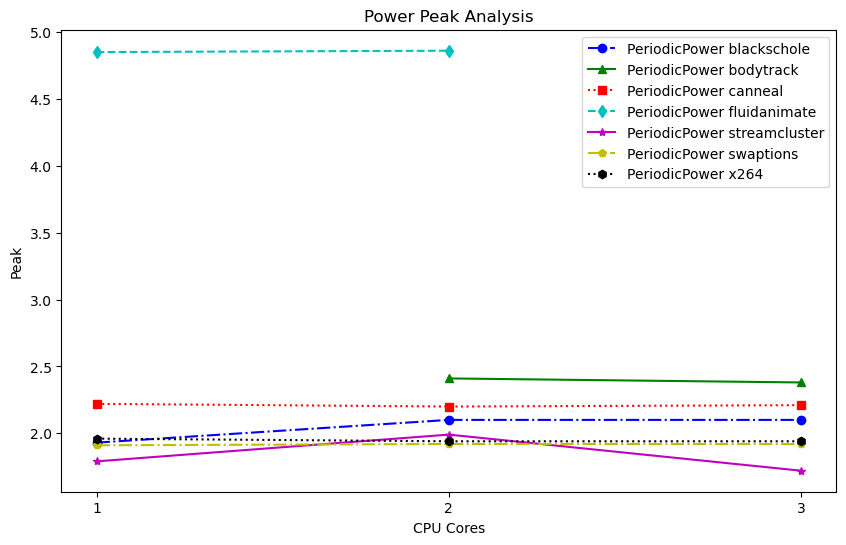

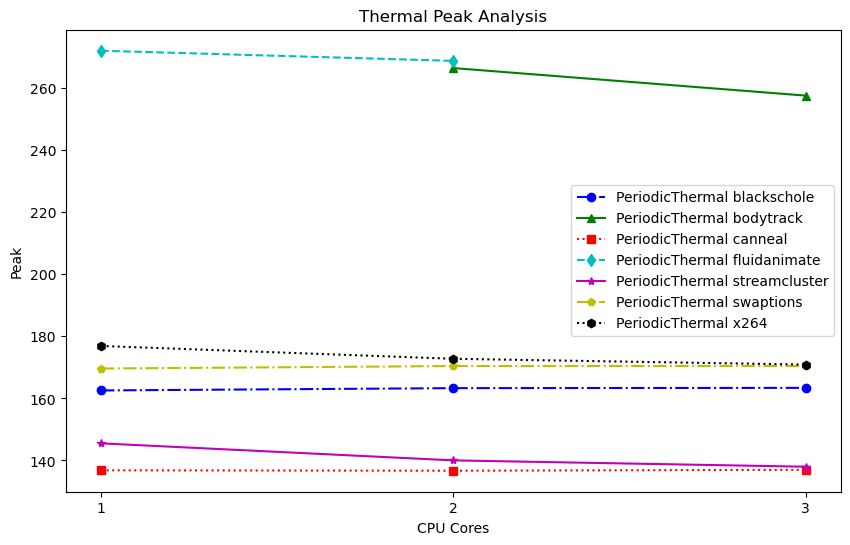

In [11]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from collections import defaultdict

def calculate_metrics(logfile_path):
    try:
        df = pd.read_csv(logfile_path, sep='\s+', header=None, skiprows=1)
    except Exception as e:
        print(f"Error reading {logfile_path}: {e}")
        return None

    if df.empty:
        return None

    # Select the largest n values for peak calculation
    peak_values = df.stack().nlargest(3)
    peak = round(peak_values.mean(), 2)

    # Calculate average, ignore data less than 0.01
    filtered_df = df[df >= 0.01]
    avg = round(filtered_df.mean().mean(), 2)

    return avg, peak

def process_log_files(directory):
    results = []
    if not os.path.exists(directory):
        print("Directory does not exist")
        return results

    for filename in os.listdir(directory):
        if filename.endswith(".log"):
            filepath = os.path.join(directory, filename)
            parts = filename.split('_')
            tag = parts[0]
            project = parts[1]
            core_count = int(parts[2].split('.')[0])

            metrics = calculate_metrics(filepath)
            if metrics:
                avg, peak = metrics
                if project == "bodytrack": # deal with special case
                    core_count += 1
                result_object = (tag, project, core_count, avg, peak)
                results.append(result_object)

    return results

log_directory = "./logs"
processed_results = process_log_files(log_directory)
print(processed_results) # Intuitively checking data for reasonableness

def plot_axes(data, metric_type, x_label, title):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Define line styles and markers
    linestyle = ['-.', '-', ':', '--', '-', '-.', ':', '--', '-', '-.']
    markers = ['o', '^', 's', 'd', '*', 'p', 'h', '+', 'x', 'v', '1', '2', '3', '4']
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    for index, (label, values) in enumerate(sorted(data.items())):
        values = sorted(values, key=lambda x: x[0])  # Sort by CPU cores
        x_values = [v[0] for v in values]
        y_values = [v[1] for v in values]

        line_color = colors[index % len(colors)]
        ax.plot(x_values, y_values, label=f'{label}',
                marker=markers[index % len(markers)], linestyle=linestyle[index % len(linestyle)], color=line_color)

    ax.legend(loc='best')

    ax.set_xlabel(x_label)
    ax.set_ylabel(metric_type)
    ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    plt.title(title)
    plt.savefig(f'{title}.pdf', bbox_inches='tight')
    plt.show()

data_by_type = defaultdict(lambda: defaultdict(list))

for tag, project, core, avg, peak in processed_results:
    data_by_type['Average'][f'{tag} {project}'].append((core, avg))
    data_by_type['Peak'][f'{tag} {project}'].append((core, peak))

for metric, data in data_by_type.items():
    plot_axes({k: v for k, v in data.items() if 'Power' in k}, metric, 'CPU Cores', f'Power {metric} Analysis')
    plot_axes({k: v for k, v in data.items() if 'Thermal' in k}, metric, 'CPU Cores', f'Thermal {metric} Analysis')
